In [2]:
import spaco
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

# benchmark on real dataset

## Load files

In [396]:
adata_cellbin = anndata.read("./data/imputation_well05.h5ad")
spatial = pd.read_csv("./data/well05_spatial.csv", index_col=0).iloc[1:,:]
adata_cellbin.obs = spatial.copy()
adata_cellbin.obsm['spatial'] = np.array(spatial.iloc[:,0:2].astype(float))

adata_cellbin_bkp = adata_cellbin.copy()

In [397]:
adata_cellbin.obs['annotation'] = adata_cellbin.obs['Main_molecular_cell_type'].copy()
adata_cellbin.obs['annotation'] = adata_cellbin.obs['annotation'].astype(str).astype('category')

## Calculations

### 1. distance calc of spaco

In [398]:
matrix_spaco_default = spaco.distance.spatial_distance(cell_coordinates=adata_cellbin.obsm['spatial'],cell_labels=adata_cellbin.obs['annotation'],radius=200, n_neighbors=30)

|-----------> Calculating cell neighborhood...
|-----------> Filtering out neighborhood outliers...
|-----------> Calculating cluster interlacement score...
|-----------> Constructing cluster interlacement graph...


In [399]:
matrix_spaco_default.to_pickle('./test_4_matrix/matrix_spaco_default.pkl')

In [400]:
cluster_index = matrix_spaco_default.index

### 2. Wasserstein

In [37]:
import pickle

In [27]:
def dump(obj,path):
    with open(path,'wb') as of:
        pickle.dump(obj,of)

In [28]:
dump(adata_cellbin.obsm['spatial'],'./test_4_matrix/spatial.np.ndarray.pkl')

In [30]:
dump(adata_cellbin.obs['annotation'],'./test_4_matrix/annotation.pd.Series.pkl')

In [ ]:
import ot

annotation = pickle.load(open('./test_4_matrix/annotation.pd.Series.pkl','rb'))
spatial = pickle.load(open('./test_4_matrix/spatial.np.ndarray.pkl','rb'))
matrix = pickle.load(open('./test_4_matrix/matrix_spaco_default.pkl','rb'))
type_index = matrix.index.to_list()

matrix_wasserstein = pd.DataFrame(0,index=type_index,columns=type_index)

N = len(type_index)
for i in range(N):
    for j in range(i+1, N):
        Ci = type_index[i]
        Cj = type_index[j]
        Ai = spatial[annotation == Ci]
        Aj = spatial[annotation == Cj]
        AM = ot.dist(Ai, Aj)
        matrix_wasserstein.iloc[i, j] = ot.emd2(
            np.ones(len(Ai))/len(Ai),
            np.ones(len(Aj))/len(Aj),
            AM
        )
        matrix_wasserstein.iloc[j, i] = matrix_wasserstein.iloc[i, j]

pickle.dump(matrix_wasserstein,open('./test_4_matrix/matrix_wasserstein.pkl','wb'))

### 3. Local Simpson index

In [8]:
import os
os.environ['R_HOME'] = '/home/jingzh/.conda/envs/spaco_dev/lib/R'

from rpy2.robjects.packages import importr
from rpy2 import robjects

In [9]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

scpop = importr('scPOP')

In [130]:
def lisi_pair(idx_i,idx_j):
    assert idx_i != idx_j
    cluster_pair = [cluster_index[idx_i], cluster_index[idx_j]]
    
    adata_cellbin_sub = adata_cellbin[adata_cellbin.obs['annotation'].isin(cluster_pair)].copy()
    
    r_dataframe = pandas2ri.py2rpy_pandasdataframe(adata_cellbin_sub.obs)
    r_coor = robjects.r.matrix(
        robjects.FloatVector(adata_cellbin_sub.obsm['spatial'].ravel()),
        nrow=len(adata_cellbin_sub),
        byrow=True
    )
    try:
        lisi_score = scpop.lisi(X = r_coor, meta_data = r_dataframe, label_colnames = 'annotation', perplexity=30)
        return lisi_score[0].mean()
    except:
        return np.nan

In [131]:
matrix_lisi = pd.DataFrame(0,index=cluster_index,columns=cluster_index)

N = len(cluster_index)
for i in range(N):
    for j in range(i+1, N):
        matrix_lisi.iloc[i, j] = lisi_pair(i,j)
        matrix_lisi.iloc[j, i] = matrix_lisi.iloc[i, j]

R[write to console]: Error in nn2(X, k = perplexity * 3, eps = nn_eps) : 
  Cannot find more nearest neighbours than there are points

R[write to console]: Error in nn2(X, k = perplexity * 3, eps = nn_eps) : 
  Cannot find more nearest neighbours than there are points

R[write to console]: Error in nn2(X, k = perplexity * 3, eps = nn_eps) : 
  Cannot find more nearest neighbours than there are points



In [133]:
matrix_lisi.to_pickle('./test_4_matrix/matrix_lisi.pkl')

### 4. Palo

In [6]:
palette_default = adata_cellbin.uns['annotation_colors'].copy()

In [9]:
palo = importr("Palo")
base = importr("base")
r = robjects.r
set_seed = r('set.seed')
set_seed(int(123))

r_coor = robjects.r.matrix(
    robjects.FloatVector(adata_cellbin.obsm['spatial'].ravel()),
    nrow=len(adata_cellbin),
    byrow=True
)

# We modified Palo function to let the function return the overlap score between clusters
palopal = palo.Palo(r_coor,adata_cellbin.obs['annotation'].to_list(),robjects.StrVector(palette_default))

In [12]:
palo_dis = pd.DataFrame(palopal)

In [25]:
matrix_palo = pd.DataFrame(0,index=cluster_index,columns=cluster_index)
for key,value in palo_dis.items():
    Ci = value[0]
    Cj = value[1]
    matrix_palo.loc[Ci,Cj] = value[2]
    matrix_palo.loc[Cj,Ci] = matrix_palo.loc[Ci,Cj]

In [26]:
matrix_palo.to_pickle('./test_4_matrix/matrix_palo.pkl')

## Distance normalization

reference：
```python

Wasserstein_sc = np.array(Wasserstein_sc)
Wasserstein_sc = - Wasserstein_sc + max(Wasserstein_sc)
...
spaco_sc_norm = (spaco_sc - min(spaco_sc)) / (max(spaco_sc) - min(spaco_sc))
Wasserstein_sc_norm = (Wasserstein_sc - min(Wasserstein_sc)) / (max(Wasserstein_sc) - min(Wasserstein_sc))
LISI_sc_norm = (LISI_sc - min(LISI_sc)) / (max(LISI_sc) - min(LISI_sc))
Palo_sc_norm = (Palo_sc - min(Palo_sc)) / (max(Palo_sc) - min(Palo_sc))
```

In [479]:
heat_df_norm = heat_df.copy()#.set_index('annotation')

In [480]:
def norm(array_):
    return (array_ - min(array_)) / (max(array_) - min(array_))

In [481]:
heat_df_norm.spaco = norm(heat_df.spaco)
heat_df_norm.lisi = norm(heat_df.lisi)
heat_df_norm.palo = norm(heat_df.palo)

In [482]:
heat_df_norm.wasserstein = norm(max(heat_df.wasserstein)-heat_df.wasserstein)

In [483]:
heat_df_norm = heat_df_norm.set_index('annotation')

## Plots

### plot heatmap: order of distance

In [401]:
# 获取序号
heat_index = []
heat_name_index = []
N = len(cluster_index)
for i in range(N):
    for j in range(i+1, N):
        Ci = cluster_index[i]
        Cj = cluster_index[j]
        heat_index.append(f'{i}:{j}')
        heat_name_index.append(f'{Ci}:{Cj}')

In [402]:
heat_df = pd.DataFrame(index=heat_index,columns=['annotation','spaco','wasserstein','lisi','palo'])

In [476]:
heat_df['annotation'] = heat_name_index

In [477]:
def ravel_dis_mat(mat):
    result = []
    for i in range(N):
        for j in range(i+1, N):
            result.append(mat.iloc[i,j])
    return result

In [478]:
heat_df['spaco'] = ravel_dis_mat(pickle.load(open('./test_4_matrix/matrix_spaco_default.pkl','rb')))

heat_df['wasserstein'] = ravel_dis_mat(pickle.load(open('./test_4_matrix/matrix_wasserstein.pkl','rb')))

heat_df['lisi'] = ravel_dis_mat(pickle.load(open('./test_4_matrix/matrix_lisi.pkl','rb')))

heat_df['palo'] = ravel_dis_mat(pickle.load(open('./test_4_matrix/matrix_palo.pkl','rb')))

In [457]:
rank_df = heat_df.copy()

In [459]:
rank_df['spaco'] = heat_df['spaco'].rank(ascending=True)
rank_df['wasserstein'] = heat_df['wasserstein'].rank(ascending=False)
rank_df['lisi'] = heat_df['lisi'].rank(ascending=True)
rank_df['palo'] = heat_df['palo'].rank(ascending=True)

In [460]:
import seaborn as sns

In [461]:
from matplotlib import pyplot as plt

<Axes: ylabel='annotation'>

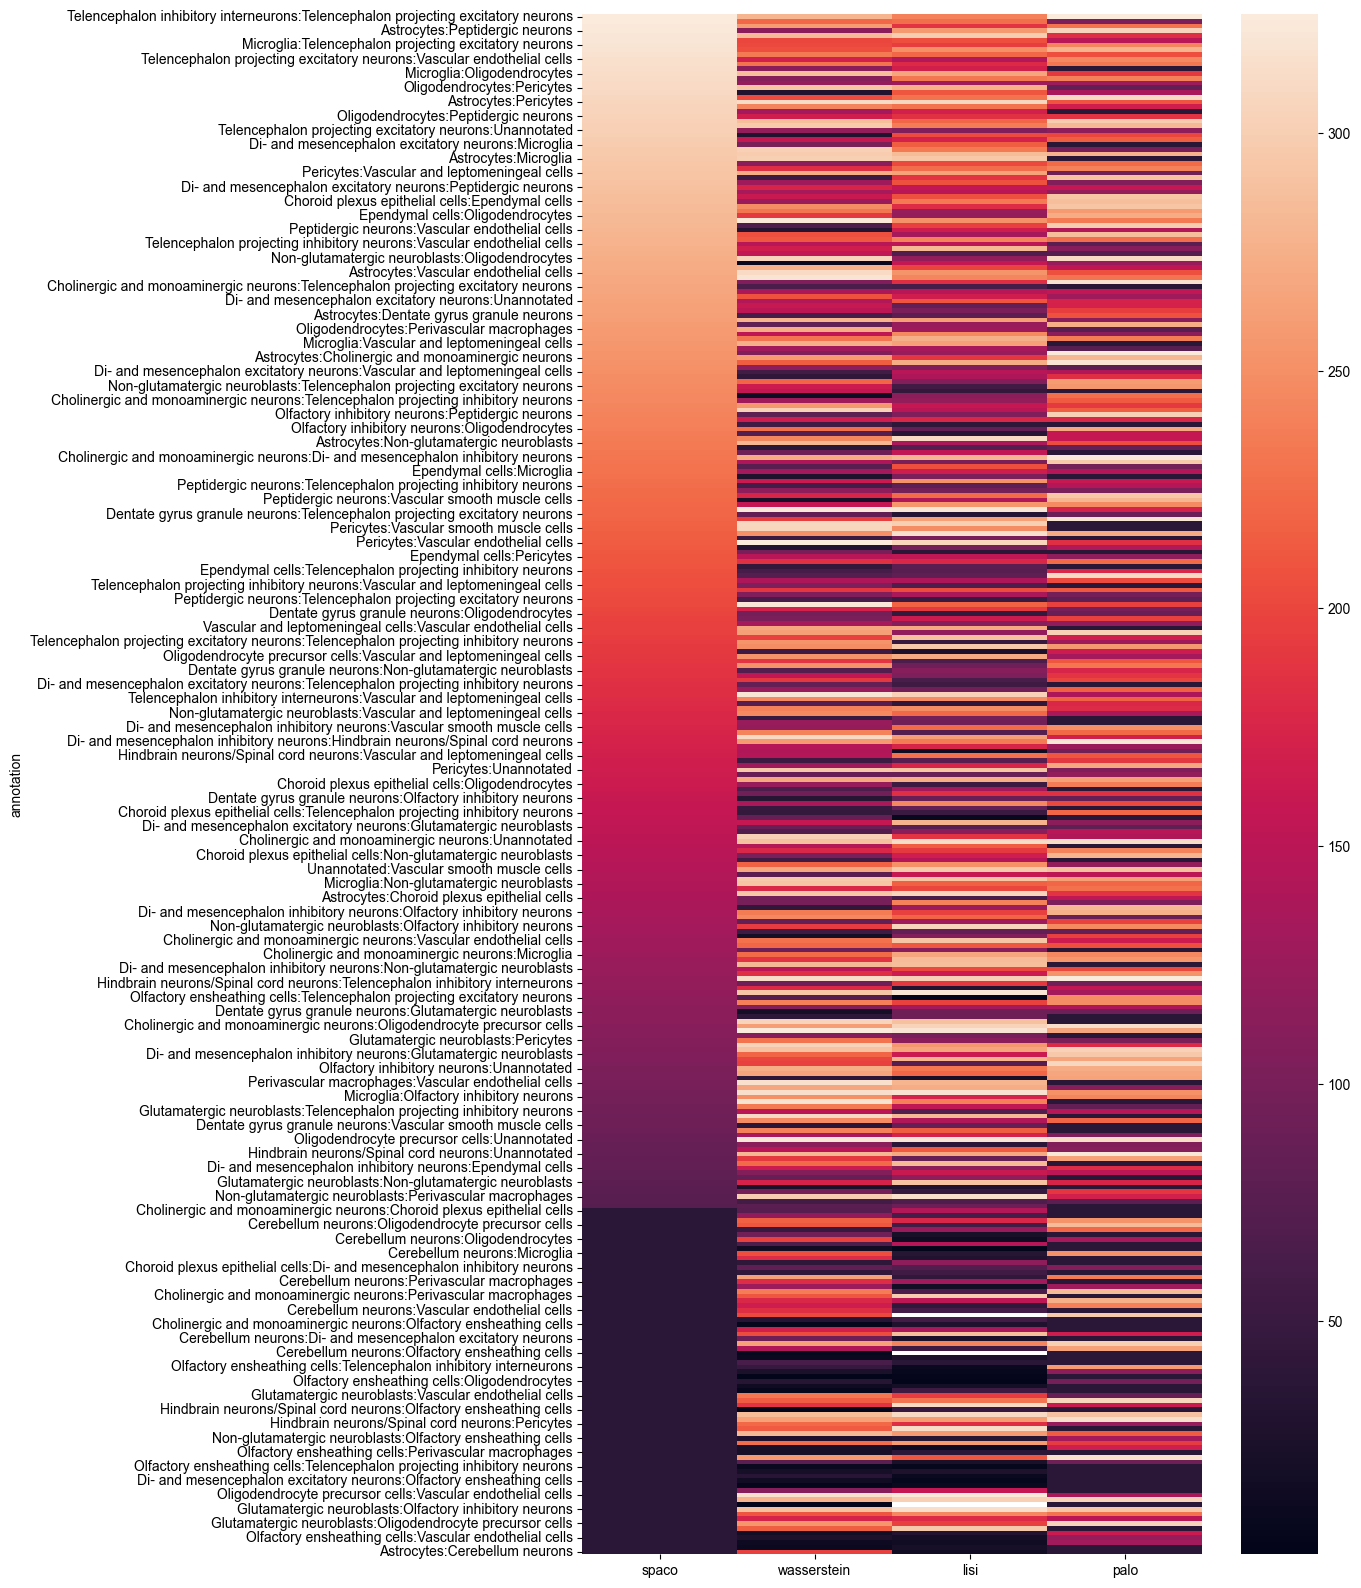

In [462]:
plt.figure(figsize=(10,20))
sns.heatmap(data=rank_df.sort_values('spaco',ascending=False).set_index('annotation'))
# plt.savefig('./test_4_matrix/rank.png',dpi=300)

### plot spatial: top 3 category pairs

In [412]:
from matplotlib import pyplot as plt

In [413]:
adata_cellbin_cp = adata_cellbin.copy()
adata_cellbin_cp.obsm['spatial'] = adata_cellbin_cp.obsm['spatial'][:,[1,0]]
adata_cellbin_cp.obsm['spatial'][:,1] = -adata_cellbin_cp.obsm['spatial'][:,1]

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"


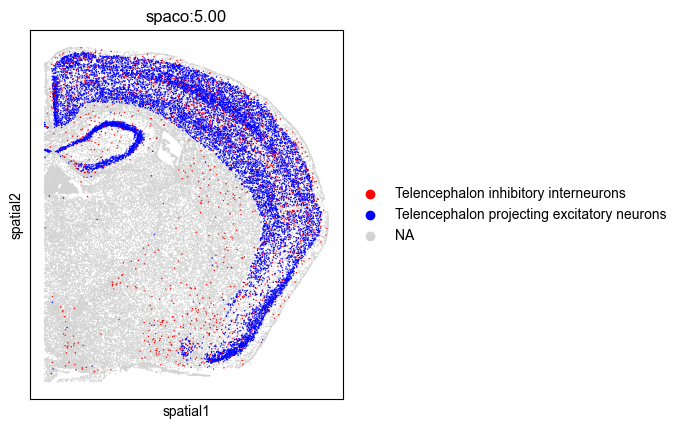

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"


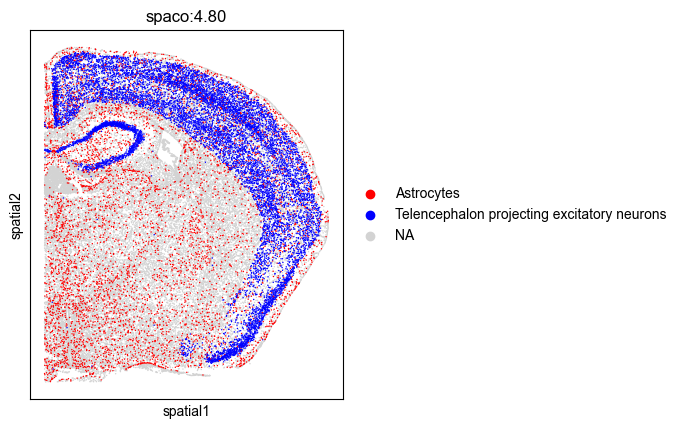

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"


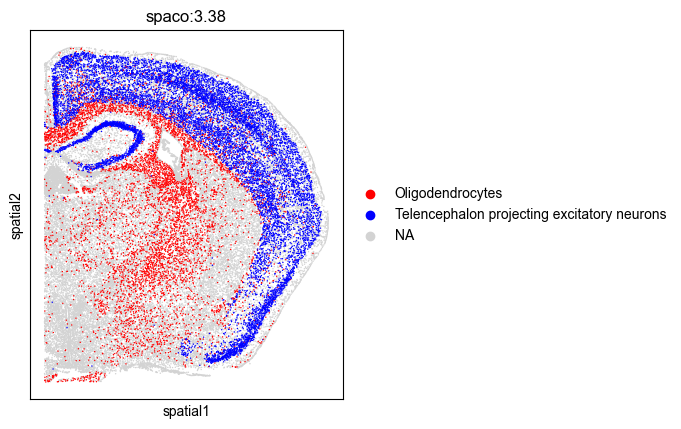

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"


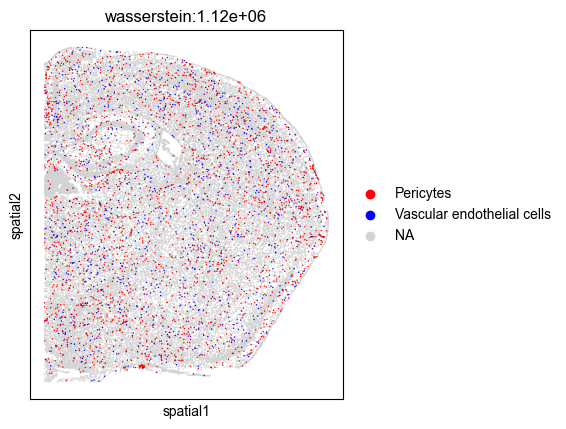

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"


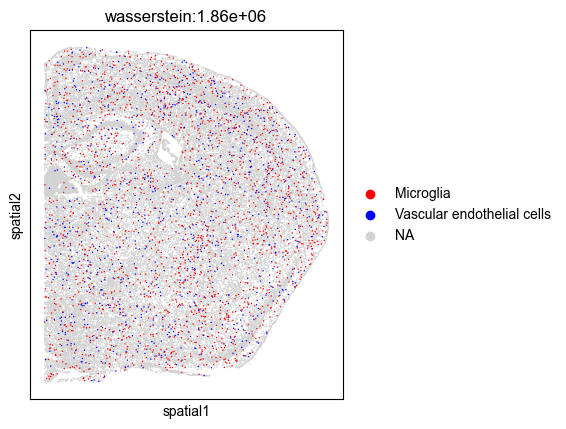

/tmp/ipykernel_3786284/1955215137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"

KeyboardInterrupt



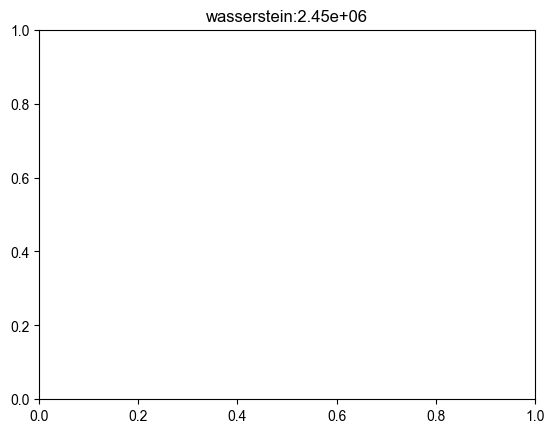

In [416]:
plt.rcParams['font.family'] = 'arial'
for method in rank_df.columns[1:]:
    for idx,pair in rank_df.sort_values(method,ascending=False)['annotation'].iloc[0:3].items():
        value = heat_df.loc[idx,method]
        if value > 100:
            value = '%.2e'%value
        else:
            value = '%.2f'%value
        adata_cellbin_cp.obs['annotation_tmp'] = adata_cellbin_cp.obs['annotation'].astype(str).copy()
        adata_cellbin_cp.obs['annotation_tmp'][~adata_cellbin_cp.obs['annotation'].isin(pair.split(':'))] = "ZZZ"
        sc.pl.spatial(
            adata_cellbin_cp,
            color="annotation_tmp",
            spot_size=135,
            groups=pair.split(':'),
            palette=["#FF0000","#0000FF","#00FF00"],
            title=f'{method}:{value}',
            save=f'/{method}:{idx}.pdf',
        )

# benchmark on simulated dataset

## Generate simulated dot groups

In [38]:
import numpy as np
import pandas as pd

In [39]:
# cate_ = pd.read_excel('./workshop/20230904_general/cate.xlsx')
cate_ = pd.DataFrame(
    [
        [100,250,50,100],
        [110,250,50,100],
        [150,250,50,100],
        [220,250,50,100],
        [400,250,50,100],
        [100,250,50,25],
        [110,250,50,25],
        [150,250,50,25],
        [220,250,50,25],
        [400,250,50,25],
    ],
    index=range(0,10),
    columns=["x","y","r","n"]
)

In [ ]:
all_cate = []
for cate,groups in cate_.iterrows():
    all_cate.append(
        pd.DataFrame(
            {
                'X': np.random.normal(groups.x, groups.r/2, groups.n),
                'Y': np.random.normal(groups.y, groups.r/2, groups.n),
                'C': cate
            }
        )
    )

In [ ]:
all_dot = pd.concat(all_cate)
all_dot.to_csv('./test_4_matrix/simulated_dots.csv',sep='\t')

In [3]:
simulated_dots = pd.read_csv('./test_4_matrix/simulated_dots.csv',sep='\t',index_col=0)

## Calculations

### 1. spaco

In [312]:
simulated_matrix_spaco_default = spaco.distance.spatial_distance(cell_coordinates=simulated_dots[['X','Y']].values,cell_labels=simulated_dots.C.values, n_cells=1)

|-----------> Calculating cell neighborhood...
|-----------> Filtering out neighborhood outliers...
|-----------> Calculating cluster interlacement score...
|-----------> Constructing cluster interlacement graph...


In [135]:
pickle.dump(simulated_matrix_spaco_default,open('./test_4_matrix/simulated_matrix_spaco_default.pkl','wb'))

### 2. Wasserstein

In [ ]:
annotation = simulated_dots.C.values
spatial = simulated_dots[['X','Y']].values
type_index = range(10)

In [ ]:
import ot

simulated_matrix_wasserstein = pd.DataFrame(0,index=type_index,columns=type_index)

N = len(type_index)
for i in range(N):
    for j in range(i+1, N):
        Ci = type_index[i]
        Cj = type_index[j]
        Ai = spatial[annotation == Ci]
        Aj = spatial[annotation == Cj]
        AM = ot.dist(Ai, Aj)
        simulated_matrix_wasserstein.iloc[i, j] = ot.emd2(
            np.ones(len(Ai))/len(Ai),
            np.ones(len(Aj))/len(Aj),
            AM
        )
        simulated_matrix_wasserstein.iloc[j, i] = simulated_matrix_wasserstein.iloc[i, j]

In [ ]:
pickle.dump(simulated_matrix_wasserstein,open('./test_4_matrix/simulated_matrix_wasserstein.pkl','wb'))

### 3. LISI

In [4]:
simulated_dots.index = range(len(simulated_dots))

In [5]:
cluster_index = range(10)
def lisi_pair(idx_i,idx_j):
    assert idx_i != idx_j
    cluster_pair = [cluster_index[idx_i], cluster_index[idx_j]]
    
    simulated_dots_sub = simulated_dots[simulated_dots['C'].isin(cluster_pair)].copy()
    # 
    
    r_dataframe = pandas2ri.py2rpy_pandasdataframe(simulated_dots_sub)
    r_coor = robjects.r.matrix(
        robjects.FloatVector(simulated_dots_sub[['X','Y']].values.ravel()),
        nrow=len(simulated_dots_sub),
        byrow=True
    )
    try:
        lisi_score = scpop.lisi(X = r_coor, meta_data = r_dataframe, label_colnames = 'C', perplexity=10)
        return lisi_score[0].mean()
    except:
        return np.nan

In [10]:
simulated_matrix_lisi = pd.DataFrame(0,index=cluster_index,columns=cluster_index)
N = len(cluster_index)
for i in range(N):
    for j in range(i+1, N):
        simulated_matrix_lisi.iloc[i, j] = lisi_pair(i,j)
        simulated_matrix_lisi.iloc[j, i] = simulated_matrix_lisi.iloc[i, j]

In [277]:
simulated_matrix_lisi.to_pickle('./test_4_matrix/simulated_matrix_lisi.pkl')

### 4. palo

In [12]:
palo = importr("Palo")
base = importr("base")
r = robjects.r
set_seed = r('set.seed')
set_seed(int(123))

r_coor = robjects.r.matrix(
    robjects.FloatVector(simulated_dots[['X','Y']].values.ravel()),
    nrow=len(simulated_dots),
    byrow=True
)

palopal = palo.Palo(r_coor,simulated_dots.C.to_list(),robjects.StrVector(palette_default[0:10]))

NameError: name 'palette_default' is not defined

In [179]:
# to matrix
palo_dis=pd.DataFrame(palopal)
cluster_index = range(10)
simulated_matrix_palo = pd.DataFrame(0,index=cluster_index,columns=cluster_index)
for key,value in palo_dis.items():
    Ci = int(value[0])
    Cj = int(value[1])
    simulated_matrix_palo.loc[Ci,Cj] = value[2]
    simulated_matrix_palo.loc[Cj,Ci] = simulated_matrix_palo.loc[Ci,Cj]

In [181]:
simulated_matrix_palo.to_pickle('./test_4_matrix/simulated_matrix_palo.pkl')

## Plots

### 1. overview of simulated datas

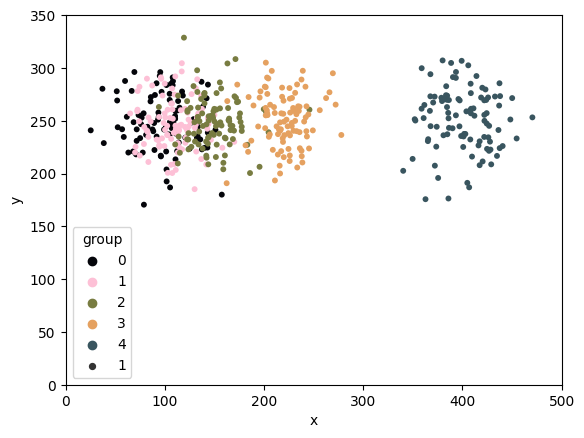

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import cmcrameri
batlowKS = [matplotlib.colors.to_hex(i) for i in cmcrameri.cm.batlowKS.colors]
sns.scatterplot(data=coor_plt[coor_plt.group.isin(['0','1','2','3','4'])],x="x", y="y", hue="group",size=1,
                palette=np.array(batlowKS[:5])[[0,1,2,4,3]].tolist(),
                linewidth=0)
plt.xlim((0,500))
plt.ylim((0,350))
plt.savefig("./test_4_matrix/all_dense.pdf")

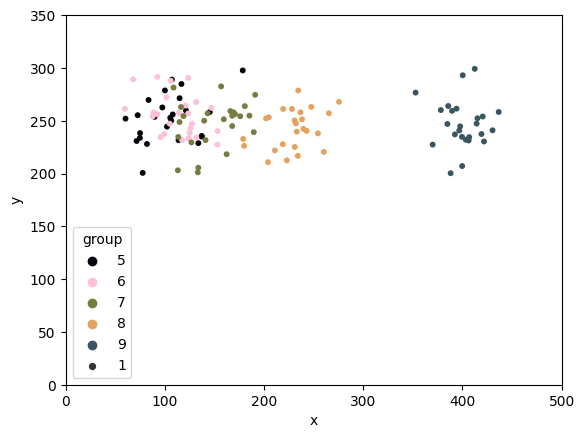

In [25]:
sns.scatterplot(data=coor_plt[~coor_plt.group.isin(['0','1','2','3','4'])],x="x", y="y", hue="group",size=1,
                palette=np.array(batlowKS[:5])[[0,1,2,4,3]].tolist(),
                linewidth=0)
plt.xlim((0,500))
plt.ylim((0,350))
plt.savefig("./test_4_matrix/all_sparse.pdf")

### 2. plot group pair scatterplots

In [13]:
coor_plt = pd.DataFrame({"x":r_coor[:,0],"y":r_coor[:,1],"group":simulated_dots.C.astype(str).to_list()})

In [214]:
def plot_simu(groups=['0','1']):
    import seaborn as sns
    sns.scatterplot(data=coor_plt[coor_plt.group.isin(groups)],x="x", y="y", hue="group",size=1)
    plt.xlim((0,500))
    plt.ylim((0,350))
    
    print("Spaco:", simulated_matrix_spaco_default.iloc[int(groups[0]), int(groups[1])])
    print("Wasserstein:", simulated_matrix_wasserstein.iloc[int(groups[0]), int(groups[1])])
    print("LISI:", simulated_matrix_lisi.iloc[int(groups[0]), int(groups[1])])
    print("Palo:", simulated_matrix_palo.iloc[int(groups[0]), int(groups[1])])

Spaco: 5.397998181254399
Wasserstein: 243.65361130270298
LISI: 1.7314560375632606
Palo: 0.7530864197530864


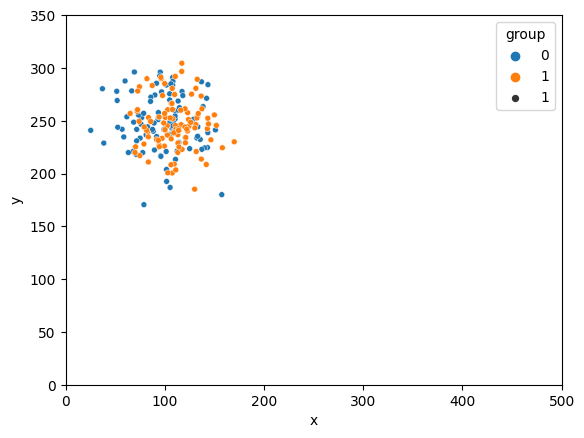

In [278]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plot_simu(groups=['0','1'])
plt.savefig("./test_4_matrix/01.pdf")

Spaco: 0.1492677215582753
Wasserstein: 449.944286238426
LISI: 1.7747910734420984
Palo: 0.7136279926335175


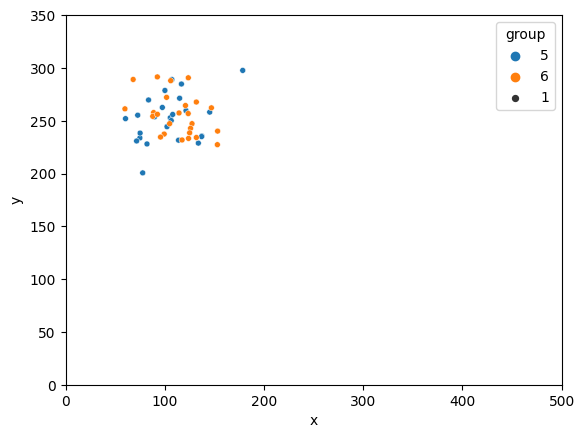

In [279]:
plot_simu(groups=['5','6'])
plt.savefig("./test_4_matrix/56.pdf")

Spaco: 1.4051257369237204
Wasserstein: 2782.5301651348063
LISI: 1.2807727158422013
Palo: 0.21332388377037562


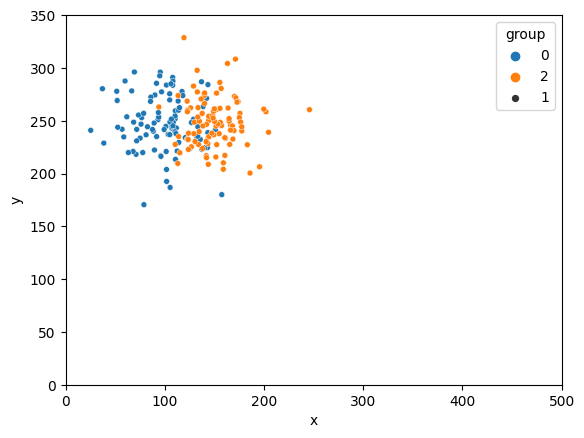

In [280]:
plot_simu(groups=['0','2'])
plt.savefig("./test_4_matrix/02.pdf")

Spaco: 0.048382565781208045
Wasserstein: 2363.680348818847
LISI: 1.4548275443705632
Palo: 0.26565589980224125


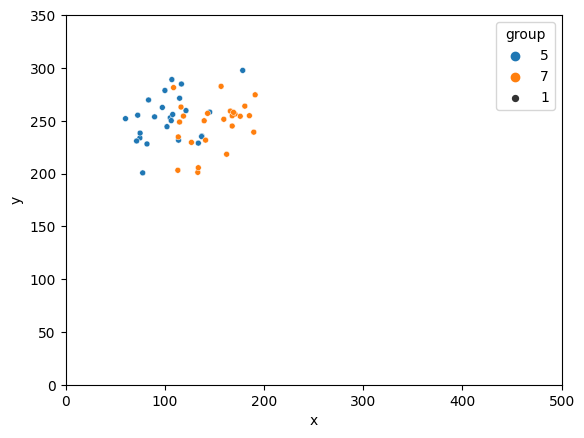

In [281]:
plot_simu(groups=['5','7'])
plt.savefig("./test_4_matrix/57.pdf")

Spaco: 0.6472671437126749
Wasserstein: 5194.258662984925
LISI: 1.117543171143491
Palo: 0.004421983575489577


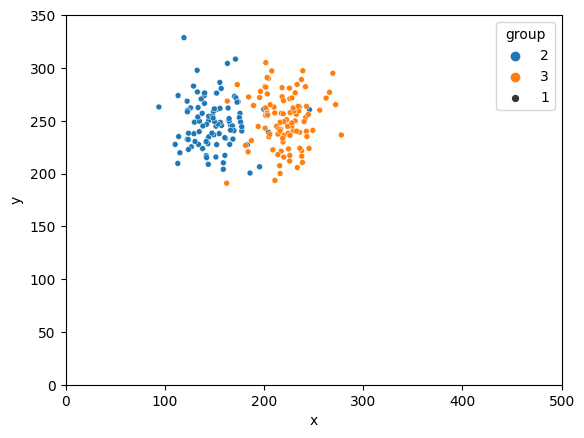

In [282]:
plot_simu(groups=['2','3'])
plt.savefig("./test_4_matrix/23.pdf")

Spaco: 0.00366810825576822
Wasserstein: 6499.967778186416
LISI: 1.1493035441404036
Palo: 0.053341148886283704


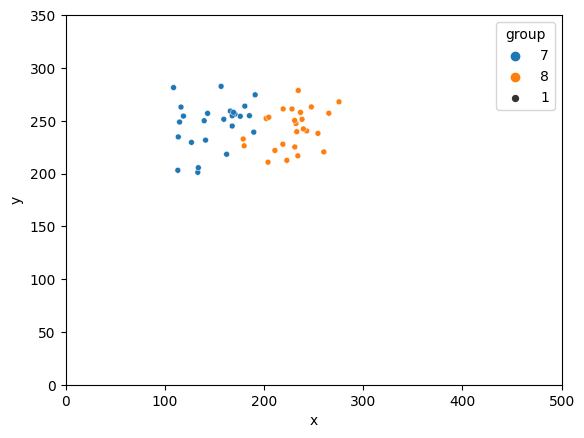

In [283]:
plot_simu(groups=['7','8'])
plt.savefig("./test_4_matrix/78.pdf")

Spaco: 0.0
Wasserstein: 15076.200240820033
LISI: 1.0152310468582768
Palo: 0.0


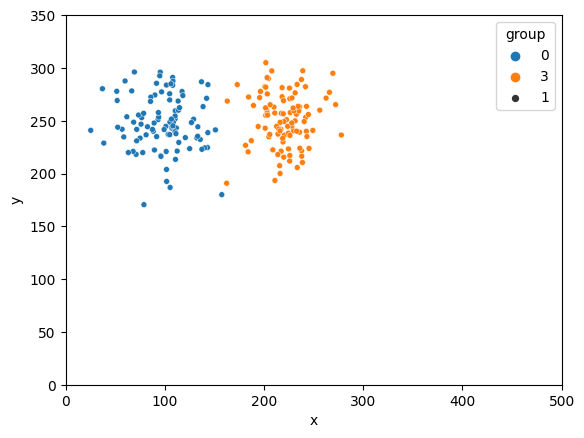

In [284]:
plot_simu(groups=['0','3'])
plt.savefig("./test_4_matrix/03.pdf")

Spaco: 0.0
Wasserstein: 15799.632891716428
LISI: 1.0340880906914913
Palo: 0.0


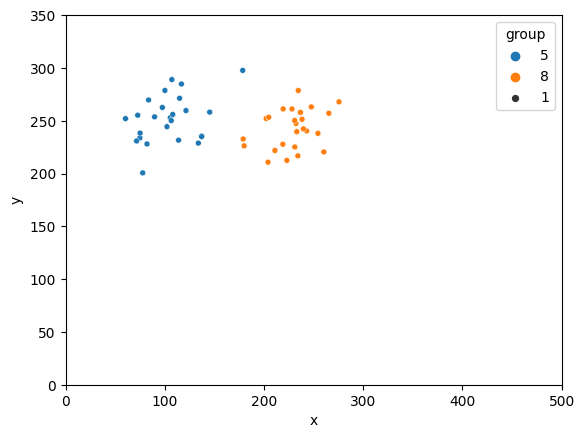

In [285]:
plot_simu(groups=['5','8'])
plt.savefig("./test_4_matrix/58.pdf")

Spaco: 0.0
Wasserstein: 91241.9461818797
LISI: 1.0000000154972095
Palo: 0.0


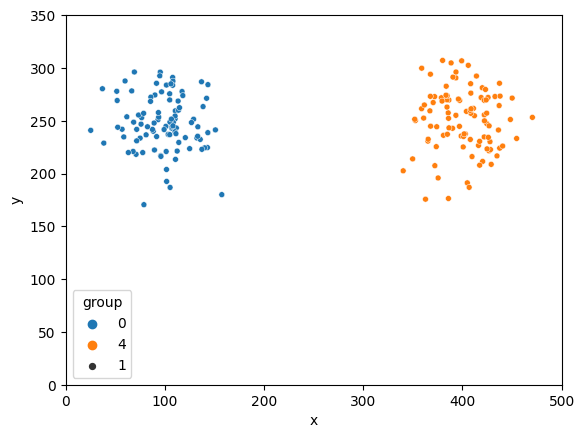

In [286]:
plot_simu(groups=['0','4'])
plt.savefig("./test_4_matrix/04.pdf")

Spaco: 0.0
Wasserstein: 88053.8065843701
LISI: 1.0000008440222294
Palo: 0.0


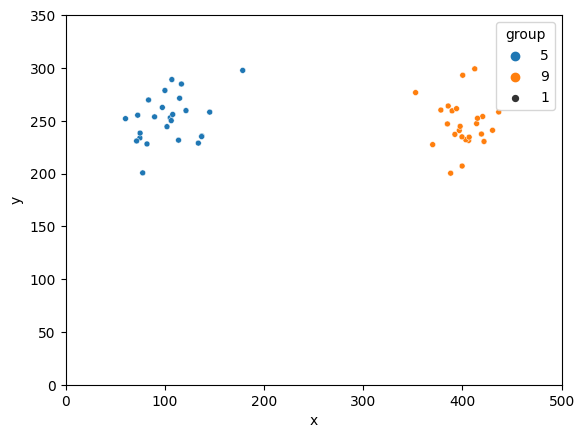

In [287]:
plot_simu(groups=['5','9'])
plt.savefig("./test_4_matrix/59.pdf")

Spaco: 1.2309900237971354
Wasserstein: 457.08075549471715
LISI: 1.4337428577304265
Palo: 0.6237533998186764


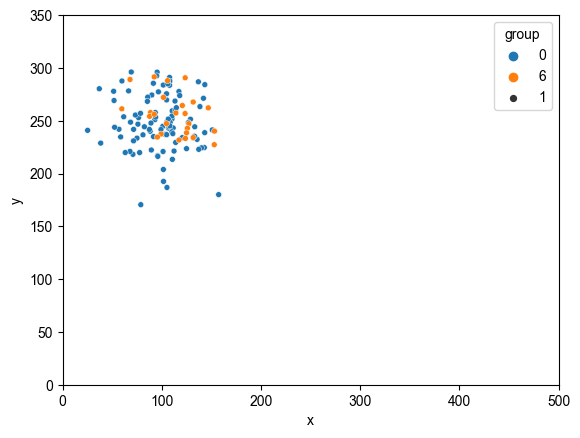

In [422]:
plot_simu(groups=['0','6'])
plt.savefig("./test_4_matrix/06.pdf")

Spaco: 0.43720099588465816
Wasserstein: 2871.261267120851
LISI: 1.231389479437945
Palo: 0.24161073825503357


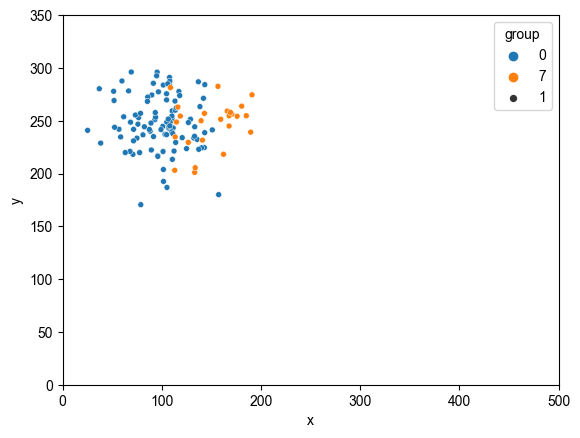

In [423]:
plot_simu(groups=['0','7'])
plt.savefig("./test_4_matrix/07.pdf")

Spaco: 0.17981343681290984
Wasserstein: 6553.802960893476
LISI: 1.112012494737267
Palo: 0.03235843186060983


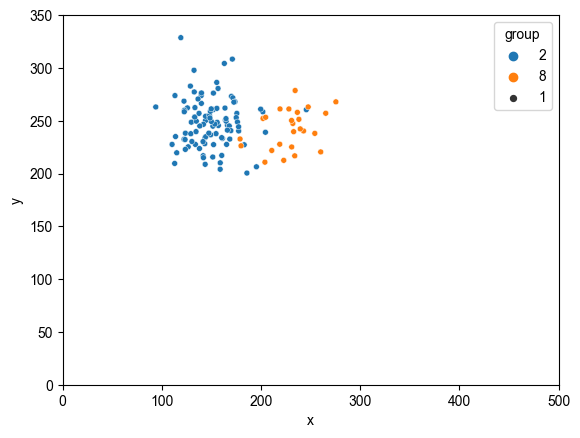

In [424]:
plot_simu(groups=['2','8'])
plt.savefig("./test_4_matrix/28.pdf")

Spaco: 0.0
Wasserstein: 17241.58892649793
LISI: 1.013605276007121
Palo: 0.0


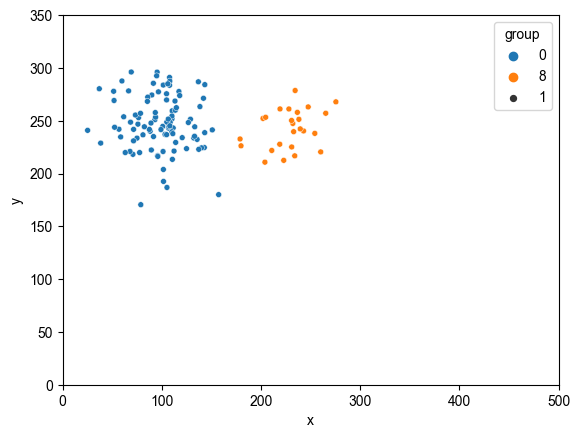

In [425]:
plot_simu(groups=['0','8'])
plt.savefig("./test_4_matrix/08.pdf")

Spaco: 0.0
Wasserstein: 91375.1796479596
LISI: 1.0000000190734888
Palo: 0.0


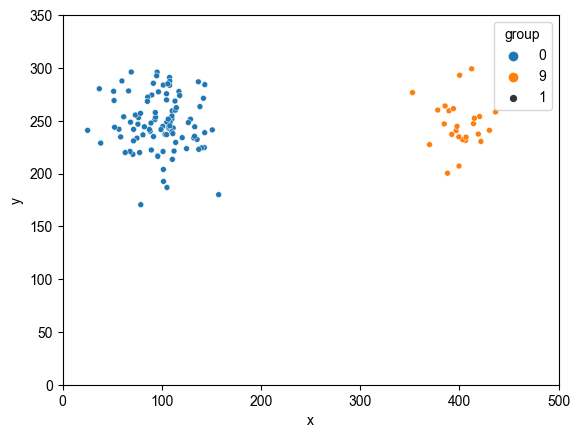

In [426]:
plot_simu(groups=['0','9'])
plt.savefig("./test_4_matrix/09.pdf")

### 3. result summary and lineplot

In [437]:
group_list = []
spaco_sc = []
Wasserstein_sc = []
LISI_sc = []
Palo_sc = []
sparse_list = []
for groups in ['01','02','23','03','04','56','57','78','58','59','06','07','28','08','09']:
    group_list.append(groups)
    if int(groups[0])>4:
        sparse_list.append(1)
    elif int(groups[1])>4:
        sparse_list.append(2)
    else:
        sparse_list.append(0)
        
    spaco_sc.append(simulated_matrix_spaco_default.iloc[int(groups[0]), int(groups[1])])
    Wasserstein_sc.append(simulated_matrix_wasserstein.iloc[int(groups[0]), int(groups[1])])
    LISI_sc.append(simulated_matrix_lisi.iloc[int(groups[0]), int(groups[1])])
    Palo_sc.append(simulated_matrix_palo.iloc[int(groups[0]), int(groups[1])])

spaco_sc = np.array(spaco_sc)
Wasserstein_sc = np.array(Wasserstein_sc)
Wasserstein_sc = - Wasserstein_sc + max(Wasserstein_sc)
#Wasserstein_sc = 1 / Wasserstein_sc
LISI_sc = np.array(LISI_sc)
Palo_sc = np.array(Palo_sc)

LISI_sc[np.isnan(LISI_sc)] = 1

spaco_sc_norm = (spaco_sc - min(spaco_sc)) / (max(spaco_sc) - min(spaco_sc))
Wasserstein_sc_norm = (Wasserstein_sc - min(Wasserstein_sc)) / (max(Wasserstein_sc) - min(Wasserstein_sc))
LISI_sc_norm = (LISI_sc - min(LISI_sc)) / (max(LISI_sc) - min(LISI_sc))
Palo_sc_norm = (Palo_sc - min(Palo_sc)) / (max(Palo_sc) - min(Palo_sc))

spaco_plt = pd.DataFrame({"group":group_list, "score":spaco_sc_norm, "method":np.repeat("spaco",len(group_list)), "sparse":sparse_list})
Wasserstein_plt = pd.DataFrame({"group":group_list, "score":Wasserstein_sc_norm, "method":np.repeat("Wasserstein",len(group_list)), "sparse":sparse_list})
LISI_plt = pd.DataFrame({"group":group_list, "score":LISI_sc_norm, "method":np.repeat("LISI",len(group_list)), "sparse":sparse_list})
Palo_plt = pd.DataFrame({"group":group_list, "score":Palo_sc_norm, "method":np.repeat("Palo",len(group_list)), "sparse":sparse_list})

df_plt = pd.concat([spaco_plt, Wasserstein_plt, LISI_plt, Palo_plt])

,group,score,method,sparse
0,01,1.000000e+00,spaco,0
1,02,2.817066e-01,spaco,0
2,23,1.328868e-01,spaco,0
3,03,9.605463e-04,spaco,0
4,04,0.000000e+00,spaco,0
5,56,6.427398e-02,spaco,1
6,57,2.584742e-02,spaco,1
7,78,3.510684e-03,spaco,1
8,58,0.000000e+00,spaco,1
9,59,0.000000e+00,spaco,1


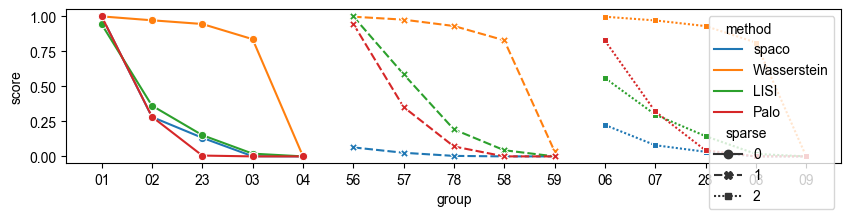

In [438]:
plt.figure(figsize=(10,2))
sns.lineplot(data=df_plt, x="group", y="score", hue="method", style="sparse",markers=True)

plt.savefig("./test_4_matrix/line_plot.pdf")